# Question 1
On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

- Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
- What metric would you report for this dataset?
- What is its value?
---


## Load Data

In [1]:
from google.colab import files
uploaded = files.upload()

Saving shopify_ds_intern_challenge_data_set.csv to shopify_ds_intern_challenge_data_set (1).csv


In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('shopify_ds_intern_challenge_data_set.csv', header=0)

## Analysis

In [5]:
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


In [7]:
# check if there's exactly 100 shops as stated in the problem
df.shop_id.nunique() == 100

True

In [8]:
# check timeframe of the data collected
print(df.created_at.min())
print(df.created_at.max())

2017-03-01 0:08:09
2017-03-30 9:55:00


In [9]:
# check numerical values
df[['order_amount', 'total_items']].describe()

,order_amount,total_items
count,5000.000000,5000.00000
mean,3145.128000,8.78720
std,41282.539349,116.32032
min,90.000000,1.00000
25%,163.000000,1.00000
50%,284.000000,2.00000
75%,390.000000,3.00000
max,704000.000000,2000.00000


Notice that order_amount has a large outlier and so does total_items.

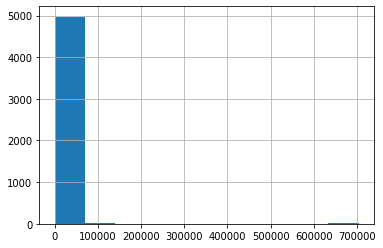

In [10]:
# check the distribution of order_amount
df.order_amount.hist()

Would like to find the average order value for each shop and check different quantiles to see if any particular shops had much higher order_amount.

In [11]:
aov_per_shop = df.groupby('shop_id').apply(lambda x: x.order_amount.sum() / len(x))
aov_per_shop.quantile([0, 0.1, 0.25, 0.5, 0.75, 0.9, 1])

0.00       162.857143
0.10       234.216000
0.25       263.675962
0.50       308.889758
0.75       336.628352
0.90       359.250435
1.00    235101.490196
dtype: float64

In [12]:
# filtering out shops with aov in the top 10 percent
aov_per_shop[aov_per_shop > aov_per_shop.quantile(0.90)].sort_values(ascending=False)

shop_id
42    235101.490196
78     49213.043478
50       403.545455
90       403.224490
38       390.857143
81       384.000000
6        383.508475
89       379.147541
33       376.275000
51       361.804348
dtype: float64

Shop #42 and shop #78 stood out! Let's see what's happening with these two stores.

In [13]:
shop42 = df[df.shop_id == 42]
shop78 = df[df.shop_id == 78]

In [14]:
shop42.order_amount.describe()

count        51.000000
mean     235101.490196
std      334860.641587
min         352.000000
25%         352.000000
50%         704.000000
75%      704000.000000
max      704000.000000
Name: order_amount, dtype: float64

In [15]:
shop42.order_amount.unique()

array([704000,    352,    704,   1056,   1760,   1408])

In [16]:
shop42[shop42.order_amount == 704000]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
1104,1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00
1436,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00
1562,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00


We can see that orders of 2000 items with a 704000 total amount are all coming from one user id and the purchases were all made using a credit card at 4am in the morning. This seems quite odd and is definitely worth looking into as it could be as sign of credit card fraud.

In [17]:
# checking to see the usual time of order creation at shop #42
shop42.created_at.str[-8:].value_counts()

 4:00:00    17
11:49:12     1
10:26:08     1
18:33:33     1
 8:21:26     1
18:10:14     1
21:31:25     1
12:19:49     1
17:51:05     1
23:00:22     1
 6:28:21     1
20:48:19     1
10:45:42     1
 1:28:31     1
14:32:58     1
23:43:45     1
12:42:26     1
 2:45:09     1
13:09:04     1
 5:42:52     1
20:10:41     1
14:15:41     1
13:10:31     1
20:50:40     1
 0:57:24     1
23:37:57     1
13:35:04     1
 2:38:34     1
22:26:58     1
 9:09:25     1
18:14:39     1
 8:11:13     1
 9:21:26     1
 0:01:19     1
14:15:15     1
Name: created_at, dtype: int64

In [18]:
shop78.order_amount.describe()

count        46.000000
mean      49213.043478
std       26472.227449
min       25725.000000
25%       25725.000000
50%       51450.000000
75%       51450.000000
max      154350.000000
Name: order_amount, dtype: float64

Note that the minimum order amount for sneakers at shop #78 is $25725.

In [19]:
shop78.order_amount.unique()

array([ 25725,  51450, 154350,  77175, 102900])

In [20]:
shop78.groupby('order_amount')['order_id'].count()

order_amount
25725     19
51450     16
77175      9
102900     1
154350     1
Name: order_id, dtype: int64

In [21]:
shop78[shop78.order_amount >= 102900]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
691,692,78,878,154350,6,debit,2017-03-27 22:51:43
2492,2493,78,834,102900,4,debit,2017-03-04 4:37:34


Shop #78 seems pretty normal, with one order of 4 and one order of 6 items purchased using a debit card, coming from different user_id. It affected the AOV calculation in the question simply because of the high unit price of its sneakers. 

A better way to evaluate this data would be to use something that's less sensitive to outliers, such as the median or IQR. For this dataset, I'd like to report IQR.

In [22]:
q1 = df.order_amount.quantile(0.25)
q3 = df.order_amount.quantile(0.75)
IQR = q3 - q1
print('IQR is {}'.format(IQR))

IQR is 227.0
